In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import urllib3

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteKVOFDF/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteKVOFDF/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [4]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [5]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [7]:
ds_info.features["label"].num_classes

10

In [8]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

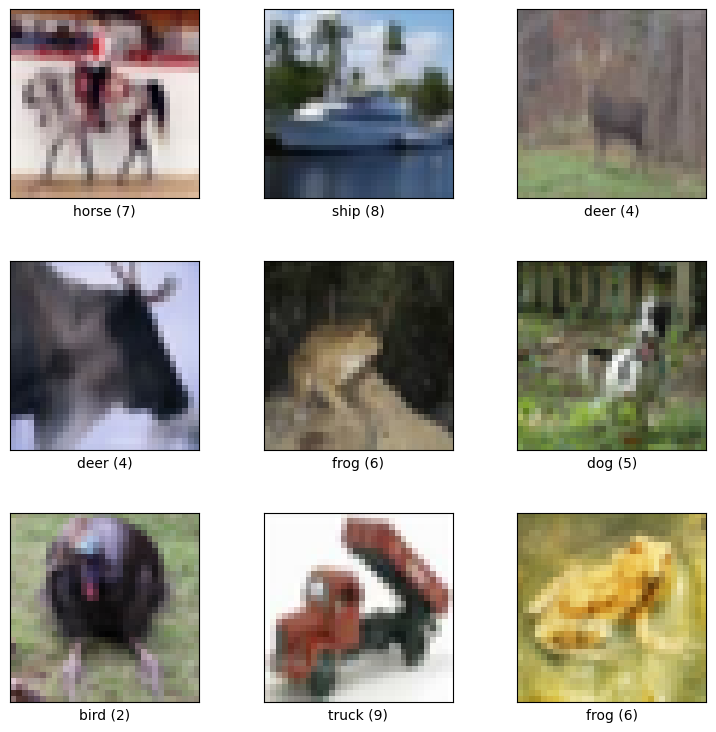

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

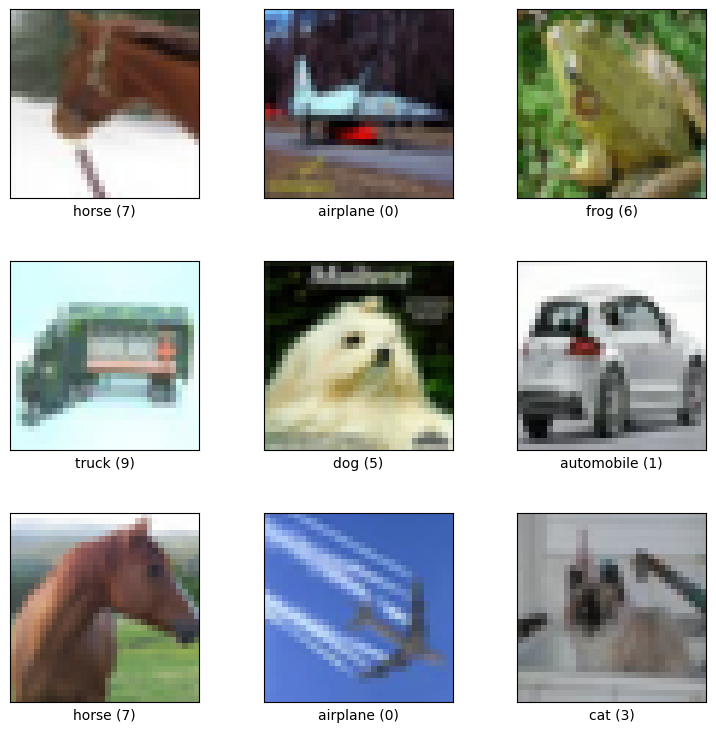

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

In [11]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [12]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [13]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

In [14]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [15]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

In [16]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

In [17]:
BATCH_SIZE = 256
EPOCH = 15

In [18]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [19]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 51s 138ms/step - loss: 2.1780 - accuracy: 0.2000 - val_loss: 2.0558 - val_accuracy: 0.2467
Epoch 2/15
195/195 [==============================] - 24s 125ms/step - loss: 1.9806 - accuracy: 0.2860 - val_loss: 1.9050 - val_accuracy: 0.3120
Epoch 3/15
195/195 [==============================] - 23s 118ms/step - loss: 1.8573 - accuracy: 0.3306 - val_loss: 1.8467 - val_accuracy: 0.3447
Epoch 4/15
195/195 [==============================] - 23s 118ms/step - loss: 1.7464 - accuracy: 0.3732 - val_loss: 1.7261 - val_accuracy: 0.3784
Epoch 5/15
195/195 [==============================] - 25s 129ms/step - loss: 1.6590 - accuracy: 0.3996 - val_loss: 1.5971 - val_accuracy: 0.4260
Epoch 6/15
195/195 [==============================] - 23s 119ms/step - loss: 1.6017 - accuracy: 0.4255 - val_loss: 1.5855 - val_accuracy: 0.4419
Epoch 7/15
195/195 [==============================] - 25s 130ms/step - loss: 1.5368 - accuracy: 0.4505 - val_loss: 1.5184 - val_ac

In [20]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 34s 146ms/step - loss: 2.2267 - accuracy: 0.1647 - val_loss: 2.1320 - val_accuracy: 0.2232
Epoch 2/15
195/195 [==============================] - 30s 152ms/step - loss: 2.0583 - accuracy: 0.2469 - val_loss: 1.9929 - val_accuracy: 0.2648
Epoch 3/15
195/195 [==============================] - 29s 147ms/step - loss: 1.9237 - accuracy: 0.3028 - val_loss: 1.8238 - val_accuracy: 0.3308
Epoch 4/15
195/195 [==============================] - 29s 147ms/step - loss: 1.8028 - accuracy: 0.3491 - val_loss: 1.7309 - val_accuracy: 0.3763
Epoch 5/15
195/195 [==============================] - 30s 153ms/step - loss: 1.7097 - accuracy: 0.3802 - val_loss: 1.7149 - val_accuracy: 0.3832
Epoch 6/15
195/195 [==============================] - 29s 148ms/step - loss: 1.6435 - accuracy: 0.4059 - val_loss: 1.6071 - val_accuracy: 0.4235
Epoch 7/15
195/195 [==============================] - 29s 148ms/step - loss: 1.5818 - accuracy: 0.4293 - val_loss: 1.5296 - val_ac

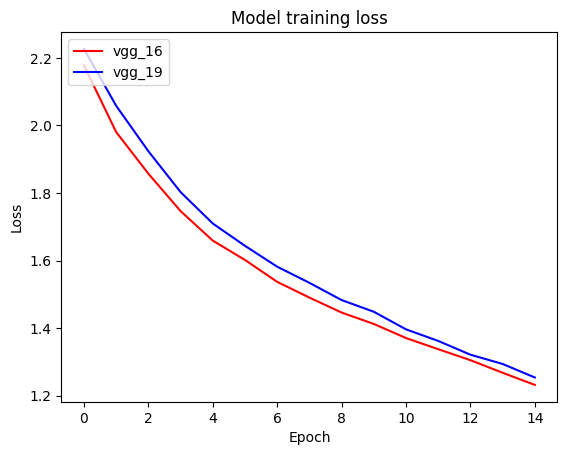

In [21]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

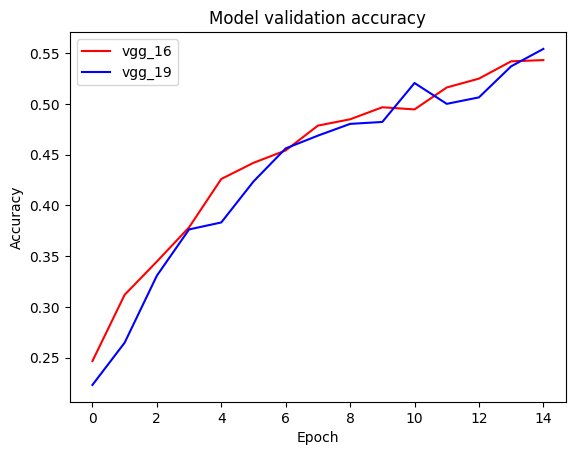

In [22]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

In [23]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.12.0
1.22.4


# - 지금부터 과제

In [28]:

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                    is_50=False,
                       plain=False,
                   ):


    flag = channel
    bn = 1
    x = input_layer
    x_identity=x

    if not is_50:
        
        for cnn_num in range(num_cnn):
            identity = x
        
            if flag :
                # 1번째 Conv
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            

            # 2번째 conv 
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn += 1
            x = keras.layers.Activation('relu')(x)
            

            
            if not plain :
     
                if flag :
                    x_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(x_identity)

                else :
                    x_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(x_identity)

                x_identity = keras.layers.BatchNormalization(
                        name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(x_identity)

                flag=True

                # AD
                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, x_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)

    else:

        for cnn_num in range(num_cnn):
            
            # 1번째 conv
            identity = x
            
            if flag :
                 x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)    
                
            else :
                x = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(x)
                

            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
        
            # 2번째 conv 
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2',
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)
            
            # 3번째 Conv
            x = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv3'
            )(x)
            x = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(x)
            bn+=1
            x = keras.layers.Activation('relu')(x)

            
            if not plain :
                
                if flag :
                    x_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(x_identity)

                else :
                    x_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(x_identity)

                x_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(x_identity)

                flag=True



                if cnn_num == 0:
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, x_identity])
                    x = keras.layers.Activation('relu')(x)
                else :
                    x = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([x, identity])
                    x = keras.layers.Activation('relu')(x)


    return x

In [29]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   

x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(resnet_input_layer)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(
    pool_size=(2, 2), 
    strides=2
)(x)

resnet_block_output = build_resnet_block(x, 
                                         channel=64, 
                                         num_cnn=3, 
                                         block_num=0)



resnet_block_output = keras.layers.AveragePooling2D(pool_size=(1,1))(resnet_block_output)
resnet_block_output = keras.layers.Flatten(name='flatten')(resnet_block_output)
resnet_block_output = keras.layers.Dense(10, activation='softmax', name='predictions')(resnet_block_output)

In [30]:
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_14 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_2[0][

In [31]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성

x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(resnet_input_layer)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(
    pool_size=(2,2), 
    strides=2
)(x)

resnet_block_output = build_resnet_block(x, 
                                         channel=64, 
                                         num_cnn=3, 
                                         block_num=0,
                                         is_50=True)



resnet_block_output = keras.layers.AveragePooling2D(pool_size=(1,1))(resnet_block_output)
resnet_block_output = keras.layers.Flatten(name='flatten')(resnet_block_output)
resnet_block_output = keras.layers.Dense(10, activation='softmax', name='predictions')(resnet_block_output)

In [32]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 16, 16, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_24 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_3[0][

In [33]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3, 4, 6, 3],
              channel_list=[64,128,256,512],
              num_classes=10,
                is_50=False,
                plain=False,):
    
    assert len(num_cnn_list) == len(channel_list) 
    
    input_layer = keras.layers.Input(shape=input_shape, name="input_layer")  
    output = input_layer 
    
    output = keras.layers.Conv2D(
        filters=channel_list[0],
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(2,2), 
        strides=2,
        name='stage2_0_maxpooling'
    )(output)
    

    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            plain=plain
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [34]:

resnet_34 = build_resnet()

resnet_34.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 64)   9472        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_37 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_4[0][

In [35]:

resnet_50 = build_resnet(
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64,128,256,512],
    is_50=True, 
)

resnet_50.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 16, 16, 64)   9472        ['input_layer[0][0]']            
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_86 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_5[0][

In [36]:
BATCH_SIZE = 256
EPOCH = 15
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [37]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 83s 284ms/step - loss: 2.2863 - accuracy: 0.2864 - val_loss: 2.2022 - val_accuracy: 0.2748
Epoch 2/15
195/195 [==============================] - 54s 275ms/step - loss: 1.6571 - accuracy: 0.4490 - val_loss: 1.8869 - val_accuracy: 0.3653
Epoch 3/15
195/195 [==============================] - 54s 278ms/step - loss: 1.2901 - accuracy: 0.5634 - val_loss: 1.7863 - val_accuracy: 0.4180
Epoch 4/15
195/195 [==============================] - 55s 281ms/step - loss: 0.9699 - accuracy: 0.6795 - val_loss: 1.8224 - val_accuracy: 0.4117
Epoch 5/15
195/195 [==============================] - 55s 284ms/step - loss: 0.7453 - accuracy: 0.7629 - val_loss: 1.7961 - val_accuracy: 0.4325
Epoch 6/15
195/195 [==============================] - 60s 309ms/step - loss: 0.5222 - accuracy: 0.8517 - val_loss: 1.8165 - val_accuracy: 0.4264
Epoch 7/15
195/195 [==============================] - 60s 309ms/step - loss: 0.3601 - accuracy: 0.9143 - val_loss: 1.8045 - val_ac

In [38]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 166s 691ms/step - loss: 2.7616 - accuracy: 0.1957 - val_loss: 2.3301 - val_accuracy: 0.1892
Epoch 2/15
195/195 [==============================] - 133s 682ms/step - loss: 2.2734 - accuracy: 0.2962 - val_loss: 2.4276 - val_accuracy: 0.2578
Epoch 3/15
195/195 [==============================] - 133s 683ms/step - loss: 2.0385 - accuracy: 0.3536 - val_loss: 2.4221 - val_accuracy: 0.3232
Epoch 4/15
195/195 [==============================] - 134s 685ms/step - loss: 1.8608 - accuracy: 0.3961 - val_loss: 2.1630 - val_accuracy: 0.3611
Epoch 5/15
195/195 [==============================] - 133s 684ms/step - loss: 1.7125 - accuracy: 0.4404 - val_loss: 2.0838 - val_accuracy: 0.3926
Epoch 6/15
195/195 [==============================] - 133s 680ms/step - loss: 1.5559 - accuracy: 0.4826 - val_loss: 2.0566 - val_accuracy: 0.3787
Epoch 7/15
195/195 [==============================] - 134s 685ms/step - loss: 1.4331 - accuracy: 0.5155 - val_loss: 1.8596 -

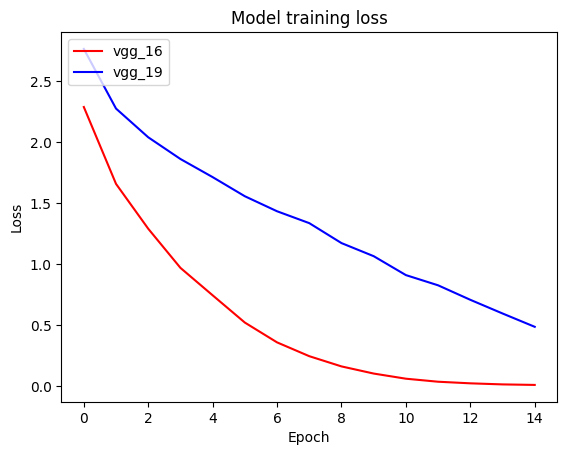

In [39]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

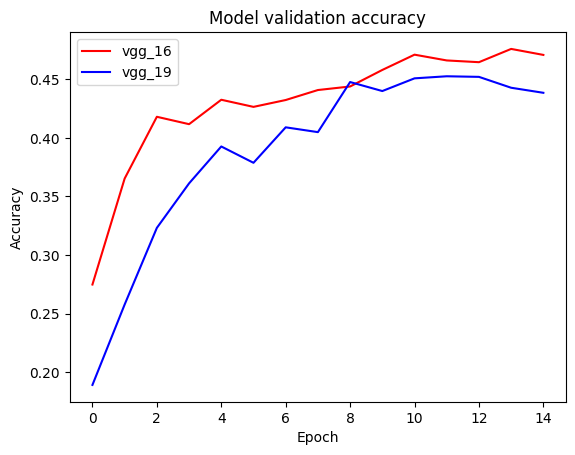

In [40]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()